In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import r2_score
from sklearn import metrics

from sklearn.metrics import classification_report

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/xebcam/DS_ML_II_2022/main/datasets/fraud_challenge.csv',encoding = "ISO-8859-1")
df.head()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,billing_postal,...,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL
0,3371.0,2167.0,56.0,2572.0,154.68.49.124,Opera/9.81.(Windows NT 10.0; ht-HT) Presto/2.9...,perez-garza.com,878-111-5140,Woodsburgh,96336.0,...,X,2020-12-29 09:05:51,Linda Wright,4684 Sharon Ranch,066-82-8795,niu_NZ,O,59.0,13646.0,legit
1,2714.0,2045.0,48.0,4517.0,39.131.125.85,Opera/9.76.(X11; Linux i686; mi-NZ) Presto/2.9...,mcneil-ortega.com,(002)736-0139,West Kevin,78083.0,...,W,2021-06-22 18:05:06,Terri Rivera,7642 Allison Ramp,669-99-9459,apn_IN,J,0.0,11930.0,legit
2,6987.0,2892.0,61.0,5007.0,166.245.194.83,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.6.20) G...,davis-calderon.com,(983)585-2863x652,Lorichester,83236.0,...,X,2021-05-10 13:48:38,Sarah Gray,4948 Lisa Passage,086-41-1624,dv_MV,T,83.0,7412.0,legit
3,2712.0,3040.0,28.0,6022.0,100.1.217.216,Mozilla/5.0 (Macintosh; Intel Mac OS X 10 9_3 ...,rose-lee.org,+1-678-897-3420x60738,Stephenmouth,78364.0,...,N,2021-03-11 07:36:40,Valerie Jenkins,1616 Little Camp,669-97-4021,byn_ER,M,24.0,4623.0,legit
4,3598.0,2976.0,66.0,2600.0,113.156.65.245,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.5.20) G...,nash.net,(013)204-1766x92641,New Brianmouth,77499.0,...,G,2021-03-27 06:13:35,Amy Coleman,149 Harris Rapid,088-21-6329,the_NP,K,21.0,1905.0,legit


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   account_age_days       149892 non-null  float64
 1   transaction_amt        149870 non-null  float64
 2   transaction_adj_amt    149886 non-null  float64
 3   historic_velocity      149885 non-null  float64
 4   ip_address             149873 non-null  object 
 5   user_agent             149887 non-null  object 
 6   email_domain           149910 non-null  object 
 7   phone_number           149873 non-null  object 
 8   billing_city           149884 non-null  object 
 9   billing_postal         149876 non-null  float64
 10  billing_state          149887 non-null  object 
 11  card_bin               149872 non-null  float64
 12  currency               149892 non-null  object 
 13  cvv                    149877 non-null  object 
 14  signature_image        149895 non-nu

In [ ]:
# DATOS FALTANTES EN TOTALES
df.isnull().sum().sum()

3000

In [ ]:
# DATOS FALTANTES EN COLUMNAS
df.isnull().sum()

account_age_days         108
transaction_amt          130
transaction_adj_amt      114
historic_velocity        115
ip_address               127
user_agent               113
email_domain              90
phone_number             127
billing_city             116
billing_postal           124
billing_state            113
card_bin                 128
currency                 108
cvv                      123
signature_image          105
transaction_type         116
transaction_env          123
EVENT_TIMESTAMP          112
applicant_name           143
billing_address          134
merchant_id              107
locale                   134
tranaction_initiate      126
days_since_last_logon    136
inital_amount            128
EVENT_LABEL                0
dtype: int64

In [ ]:
# VERIFICAR QUE COLUMNAS CONTIENEN DATOS CONTINUOS
con_cols = [col for col in df.columns if df[col].dtype != 'O']
con_cols

['account_age_days',
 'transaction_amt',
 'transaction_adj_amt',
 'historic_velocity',
 'billing_postal',
 'card_bin',
 'days_since_last_logon',
 'inital_amount']

In [ ]:
# VERIFICAR QUE COLUMNAS TIENEN DATOS CATEGORICOS
col_categorical = [var for var in df.columns if df[var].dtype=='O']
for i in col_categorical:
    print(f"{i}: {len(df[i].unique())} labels")

ip_address: 13669 labels
user_agent: 8830 labels
email_domain: 7144 labels
phone_number: 12217 labels
billing_city: 9188 labels
billing_state: 51 labels
currency: 4 labels
cvv: 27 labels
signature_image: 27 labels
transaction_type: 27 labels
transaction_env: 27 labels
EVENT_TIMESTAMP: 149554 labels
applicant_name: 97404 labels
billing_address: 149861 labels
merchant_id: 149884 labels
locale: 294 labels
tranaction_initiate: 27 labels
EVENT_LABEL: 2 labels


# Pre-Procesamiento de datos

## DATO FORMATO A LA COLUMNAS

In [ ]:
def format_column_names(df):
    df.columns = df.columns.str.lower().str.replace(" ","_", regex=True)
    df.columns = df.columns.str.replace(".","_", regex=True)
    df.columns = df.columns.str.replace("-","_", regex=True)
    df.columns = df.columns.str.replace(":","_", regex=True)

In [ ]:

format_column_names(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   account_age_days       149892 non-null  float64
 1   transaction_amt        149870 non-null  float64
 2   transaction_adj_amt    149886 non-null  float64
 3   historic_velocity      149885 non-null  float64
 4   ip_address             149873 non-null  object 
 5   user_agent             149887 non-null  object 
 6   email_domain           149910 non-null  object 
 7   phone_number           149873 non-null  object 
 8   billing_city           149884 non-null  object 
 9   billing_postal         149876 non-null  float64
 10  billing_state          149887 non-null  object 
 11  card_bin               149872 non-null  float64
 12  currency               149892 non-null  object 
 13  cvv                    149877 non-null  object 
 14  signature_image        149895 non-nu

In [ ]:
# VERIFICAR QUE COLUMNAS TIENEN DATOS CATEGORICOS
col_categorical = [var for var in df.columns if df[var].dtype=='O']
for i in col_categorical:
    print(f"{i}: {len(df[i].unique())} labels")

ip_address: 13669 labels
user_agent: 8830 labels
email_domain: 7144 labels
phone_number: 12217 labels
billing_city: 9188 labels
billing_state: 51 labels
currency: 4 labels
cvv: 27 labels
signature_image: 27 labels
transaction_type: 27 labels
transaction_env: 27 labels
event_timestamp: 149554 labels
applicant_name: 97404 labels
billing_address: 149861 labels
merchant_id: 149884 labels
locale: 294 labels
tranaction_initiate: 27 labels
event_label: 2 labels


In [ ]:
df.isnull().sum()

account_age_days         108
transaction_amt          130
transaction_adj_amt      114
historic_velocity        115
ip_address               127
user_agent               113
email_domain              90
phone_number             127
billing_city             116
billing_postal           124
billing_state            113
card_bin                 128
currency                 108
cvv                      123
signature_image          105
transaction_type         116
transaction_env          123
event_timestamp          112
applicant_name           143
billing_address          134
merchant_id              107
locale                   134
tranaction_initiate      126
days_since_last_logon    136
inital_amount            128
event_label                0
dtype: int64

In [ ]:
df['event_label'].unique()

array(['legit', 'fraud'], dtype=object)

##IDENTIFICAMOS NUESTRAS CLASES '0' Y '1'
- 1 = 'fraud' -> Existe fraude
- 0 = 'legit' -> NO existe fraude

In [ ]:
#CONVERTIMOS NUESTROS DATOS CATEGORICOS A DATOS CONTINUOS
def col_cat_con(col_categorical ,df):
    for i in col_categorical :
        df[i] = df[i].astype('category').cat.codes

In [ ]:
col_cat_con(col_categorical ,df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   account_age_days       149892 non-null  float64
 1   transaction_amt        149870 non-null  float64
 2   transaction_adj_amt    149886 non-null  float64
 3   historic_velocity      149885 non-null  float64
 4   ip_address             150000 non-null  int16  
 5   user_agent             150000 non-null  int16  
 6   email_domain           150000 non-null  int16  
 7   phone_number           150000 non-null  int16  
 8   billing_city           150000 non-null  int16  
 9   billing_postal         149876 non-null  float64
 10  billing_state          150000 non-null  int8   
 11  card_bin               149872 non-null  float64
 12  currency               150000 non-null  int8   
 13  cvv                    150000 non-null  int8   
 14  signature_image        150000 non-nu

In [ ]:
df['event_label'] = df['event_label'].replace({1: 0, 0: 1})  #REMPLAZAMOS LA MALA CODIFICACION DE DATOA DE 'legit'=1 y 'fraud'=0 por 'fraud'=1 y 'legit'=0
df.head()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,billing_postal,...,transaction_env,event_timestamp,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,event_label
0,3371.0,2167.0,56.0,2572.0,3785,8596,4950,11500,9136,96336.0,...,23,26621,58524,70493,11086,202,14,59.0,13646.0,0
1,2714.0,2045.0,48.0,4517.0,9536,8537,4138,3,8732,78083.0,...,22,98395,90070,114672,111651,7,9,0.0,11930.0,0
2,6987.0,2892.0,61.0,5007.0,4570,4741,1449,2394,3871,83236.0,...,23,80755,82433,74525,14332,76,19,83.0,7412.0,0
3,2712.0,3040.0,28.0,6022.0,113,1221,5585,3774,7920,78364.0,...,13,55984,94133,24247,111646,55,12,24.0,4623.0,0
4,3598.0,2976.0,66.0,2600.0,991,4669,4569,39,4473,77499.0,...,6,62453,4141,22357,14611,261,10,21.0,1905.0,0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


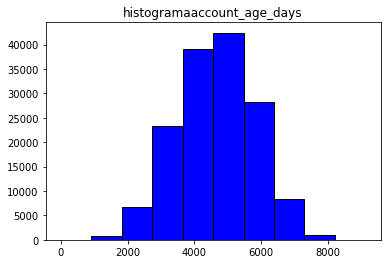

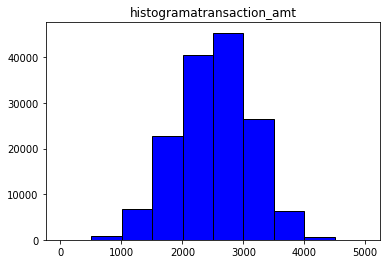

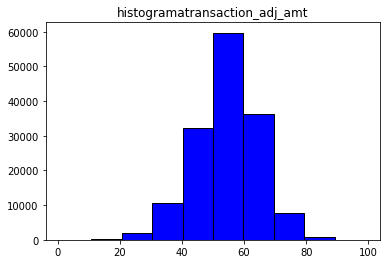

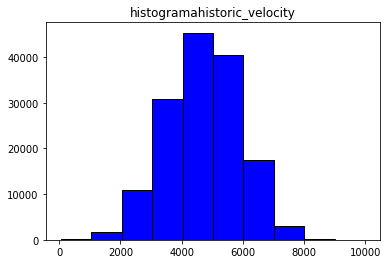

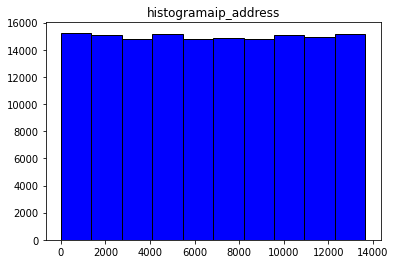

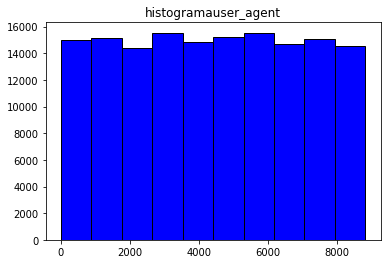

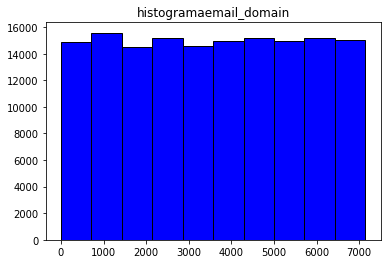

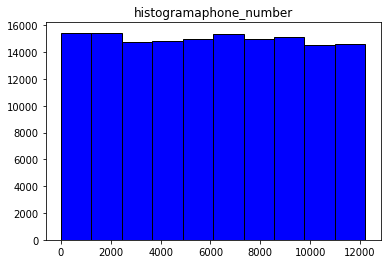

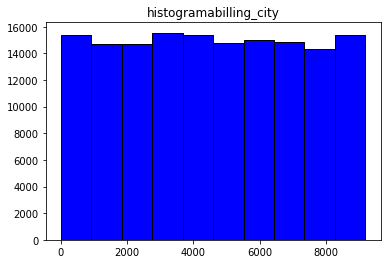

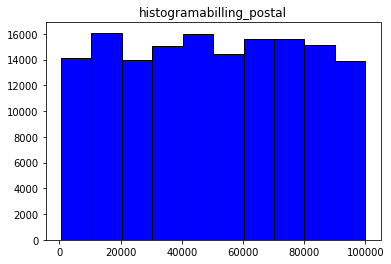

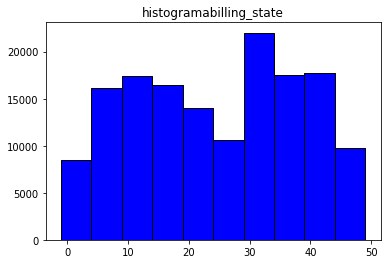

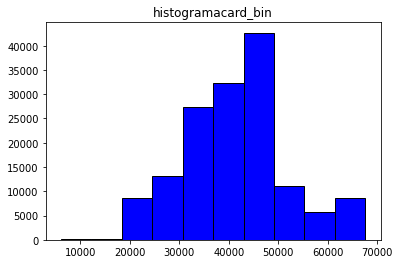

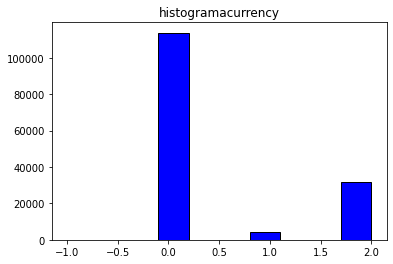

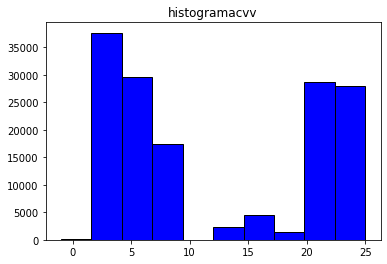

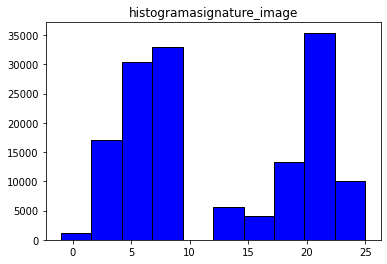

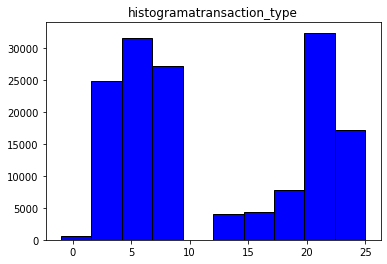

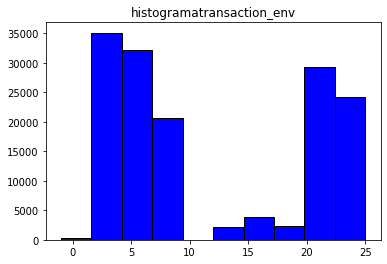

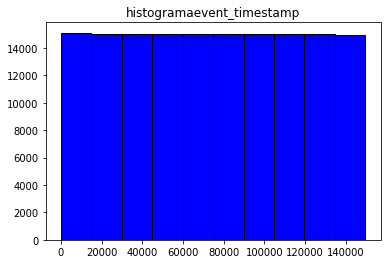

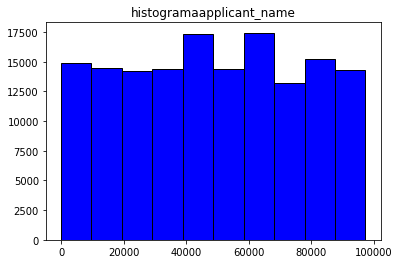

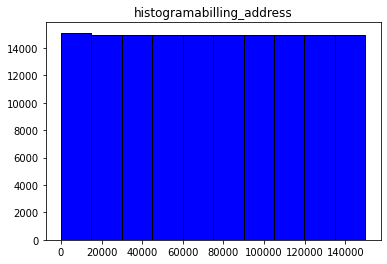

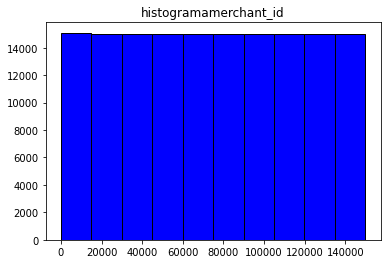

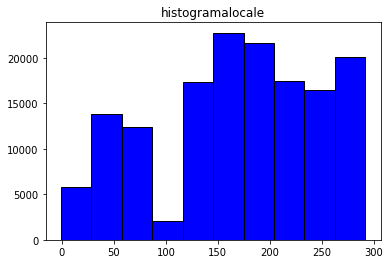

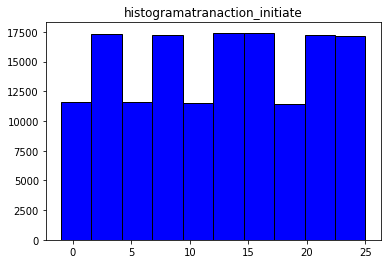

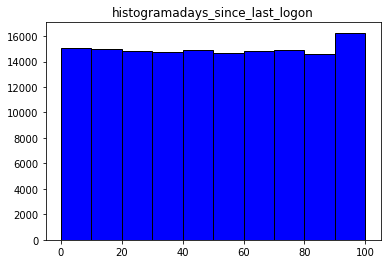

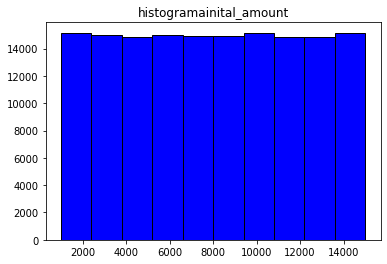

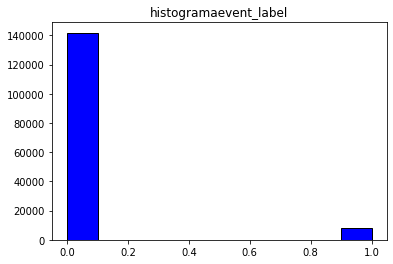

In [ ]:
def crear_histogra(variable,j):
  plt.figure(j)
  plt.hist(df[variable],10,color = "blue" , ec="black")
  plt.title("histograma"+variable)

variable=list(df.columns.values)

j = 0
k = 0

for i in variable:
  crear_histogra(i,j)
  j+=1
  k+=1



:ELIMINAMOS LAS COLUMNAS QUE NO TENGAN RELEVANCIA

In [ ]:
df.drop(['ip_address','user_agent','email_domain','phone_number','billing_city','billing_postal',
         'billing_state','event_timestamp','applicant_name','billing_address','merchant_id','tranaction_initiate',
         'days_since_last_logon','inital_amount'],axis=1,inplace=True)
format_column_names(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   account_age_days     149892 non-null  float64
 1   transaction_amt      149870 non-null  float64
 2   transaction_adj_amt  149886 non-null  float64
 3   historic_velocity    149885 non-null  float64
 4   card_bin             149872 non-null  float64
 5   currency             150000 non-null  int8   
 6   cvv                  150000 non-null  int8   
 7   signature_image      150000 non-null  int8   
 8   transaction_type     150000 non-null  int8   
 9   transaction_env      150000 non-null  int8   
 10  locale               150000 non-null  int16  
 11  event_label          150000 non-null  int64  
dtypes: float64(5), int16(1), int64(1), int8(5)
memory usage: 7.9 MB


##IMPUTAR DATOS FALTANTES

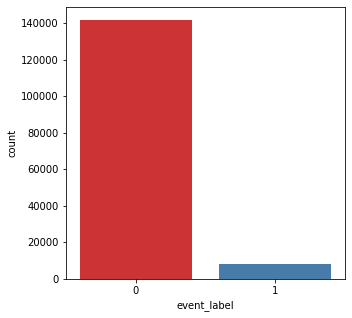

In [ ]:
f, ax = plt.subplots(figsize=(5, 5))
ax = sns.countplot(x="event_label", data=df, palette="Set1")
plt.show()

##Imputar datos faltantes con KNNImputer

In [ ]:
#SE IMPUTAN LOS DATOS
imputer = KNNImputer(n_neighbors=5)
df.iloc[:,:] = imputer.fit_transform(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   account_age_days     150000 non-null  float64
 1   transaction_amt      150000 non-null  float64
 2   transaction_adj_amt  150000 non-null  float64
 3   historic_velocity    150000 non-null  float64
 4   card_bin             150000 non-null  float64
 5   currency             150000 non-null  float64
 6   cvv                  150000 non-null  float64
 7   signature_image      150000 non-null  float64
 8   transaction_type     150000 non-null  float64
 9   transaction_env      150000 non-null  float64
 10  locale               150000 non-null  float64
 11  event_label          150000 non-null  float64
dtypes: float64(12)
memory usage: 13.7 MB


In [ ]:
#SE VERIFICA SI LAS COLUMNAS SIGUEN TENIENDO DATOS FALTANTES
df.isnull().sum()

account_age_days       0
transaction_amt        0
transaction_adj_amt    0
historic_velocity      0
card_bin               0
currency               0
cvv                    0
signature_image        0
transaction_type       0
transaction_env        0
locale                 0
event_label            0
dtype: int64

In [ ]:
dfescalar = df.loc[:,'account_age_days':'locale']
dfescalar.head()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,card_bin,currency,cvv,signature_image,transaction_type,transaction_env,locale
0,3371.0,2167.0,56.0,2572.0,40771.0,0.0,3.0,5.0,20.0,23.0,202.0
1,2714.0,2045.0,48.0,4517.0,24480.0,0.0,23.0,23.0,7.0,22.0,7.0
2,6987.0,2892.0,61.0,5007.0,37778.0,0.0,23.0,16.0,23.0,23.0,76.0
3,2712.0,3040.0,28.0,6022.0,55790.0,2.0,6.0,6.0,2.0,13.0,55.0
4,3598.0,2976.0,66.0,2600.0,37370.0,0.0,23.0,5.0,5.0,6.0,261.0


In [ ]:
#escalar datos 
nombres_colms = dfescalar.columns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

dfEscalado = ColumnTransformer([('escalar',MinMaxScaler(feature_range=(0,1)),nombres_colms)])
dfEscalado

ColumnTransformer(transformers=[('escalar', MinMaxScaler(),
                                 Index(['account_age_days', 'transaction_amt', 'transaction_adj_amt',
       'historic_velocity', 'card_bin', 'currency', 'cvv', 'signature_image',
       'transaction_type', 'transaction_env', 'locale'],
      dtype='object'))])

In [ ]:
dfEs = dfEscalado.fit_transform(dfescalar)
dfEs

array([[0.3695986 , 0.4329195 , 0.56122449, ..., 0.80769231, 0.92307692,
        0.69283276],
       [0.29754332, 0.40849019, 0.47959184, ..., 0.30769231, 0.88461538,
        0.02730375],
       [0.76617679, 0.57809371, 0.6122449 , ..., 0.92307692, 0.92307692,
        0.26279863],
       ...,
       [0.52423777, 0.67400881, 0.47959184, ..., 0.34615385, 0.15384615,
        0.95904437],
       [0.66725159, 0.4607529 , 0.59183673, ..., 1.        , 0.92307692,
        0.55631399],
       [0.56810704, 0.62935523, 0.68367347, ..., 1.        , 1.        ,
        0.55631399]])

In [ ]:
datosEscalados = pd.DataFrame(dfEs)
datosEscalados

,0,1,2,3,4,5,6,7,8,9,10
0,0.369599,0.432920,0.561224,0.253493,0.563824,0.333333,0.153846,0.230769,0.807692,0.923077,0.692833
1,0.297543,0.408490,0.479592,0.448990,0.299356,0.333333,0.923077,0.923077,0.307692,0.884615,0.027304
2,0.766177,0.578094,0.612245,0.498241,0.515236,0.333333,0.923077,0.653846,0.923077,0.923077,0.262799
3,0.297324,0.607729,0.275510,0.600261,0.807643,1.000000,0.269231,0.269231,0.115385,0.538462,0.191126
4,0.394494,0.594914,0.663265,0.256307,0.508612,0.333333,0.923077,0.230769,0.230769,0.269231,0.894198
...,...,...,...,...,...,...,...,...,...,...,...
149995,0.437048,0.577693,0.571429,0.451704,0.389243,0.333333,0.884615,0.153846,0.730769,0.884615,0.976109
149996,0.639724,0.374449,0.612245,0.434114,0.965389,0.333333,0.346154,0.923077,0.884615,1.000000,0.897611
149997,0.524238,0.674009,0.479592,0.511107,0.666228,0.333333,0.153846,0.307692,0.346154,0.153846,0.959044
149998,0.667252,0.460753,0.591837,0.482058,0.322262,0.333333,0.923077,0.807692,1.000000,0.923077,0.556314


In [ ]:
datosEscalados.columns = list(dfescalar.columns.values)
datosEscalados

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,card_bin,currency,cvv,signature_image,transaction_type,transaction_env,locale
0,0.369599,0.432920,0.561224,0.253493,0.563824,0.333333,0.153846,0.230769,0.807692,0.923077,0.692833
1,0.297543,0.408490,0.479592,0.448990,0.299356,0.333333,0.923077,0.923077,0.307692,0.884615,0.027304
2,0.766177,0.578094,0.612245,0.498241,0.515236,0.333333,0.923077,0.653846,0.923077,0.923077,0.262799
3,0.297324,0.607729,0.275510,0.600261,0.807643,1.000000,0.269231,0.269231,0.115385,0.538462,0.191126
4,0.394494,0.594914,0.663265,0.256307,0.508612,0.333333,0.923077,0.230769,0.230769,0.269231,0.894198
...,...,...,...,...,...,...,...,...,...,...,...
149995,0.437048,0.577693,0.571429,0.451704,0.389243,0.333333,0.884615,0.153846,0.730769,0.884615,0.976109
149996,0.639724,0.374449,0.612245,0.434114,0.965389,0.333333,0.346154,0.923077,0.884615,1.000000,0.897611
149997,0.524238,0.674009,0.479592,0.511107,0.666228,0.333333,0.153846,0.307692,0.346154,0.153846,0.959044
149998,0.667252,0.460753,0.591837,0.482058,0.322262,0.333333,0.923077,0.807692,1.000000,0.923077,0.556314


In [ ]:
dfcopy=df.copy()
df=df['event_label']
df

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
149995    0.0
149996    0.0
149997    0.0
149998    0.0
149999    0.0
Name: event_label, Length: 150000, dtype: float64

In [ ]:
df = pd.concat([datosEscalados,df],axis=1)
df

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,card_bin,currency,cvv,signature_image,transaction_type,transaction_env,locale,event_label
0,0.369599,0.432920,0.561224,0.253493,0.563824,0.333333,0.153846,0.230769,0.807692,0.923077,0.692833,0.0
1,0.297543,0.408490,0.479592,0.448990,0.299356,0.333333,0.923077,0.923077,0.307692,0.884615,0.027304,0.0
2,0.766177,0.578094,0.612245,0.498241,0.515236,0.333333,0.923077,0.653846,0.923077,0.923077,0.262799,0.0
3,0.297324,0.607729,0.275510,0.600261,0.807643,1.000000,0.269231,0.269231,0.115385,0.538462,0.191126,0.0
4,0.394494,0.594914,0.663265,0.256307,0.508612,0.333333,0.923077,0.230769,0.230769,0.269231,0.894198,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,0.437048,0.577693,0.571429,0.451704,0.389243,0.333333,0.884615,0.153846,0.730769,0.884615,0.976109,0.0
149996,0.639724,0.374449,0.612245,0.434114,0.965389,0.333333,0.346154,0.923077,0.884615,1.000000,0.897611,0.0
149997,0.524238,0.674009,0.479592,0.511107,0.666228,0.333333,0.153846,0.307692,0.346154,0.153846,0.959044,0.0
149998,0.667252,0.460753,0.591837,0.482058,0.322262,0.333333,0.923077,0.807692,1.000000,0.923077,0.556314,0.0


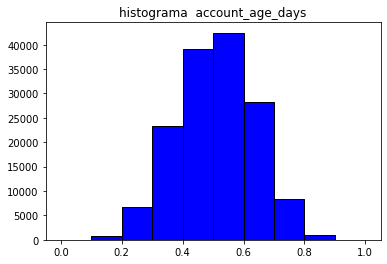

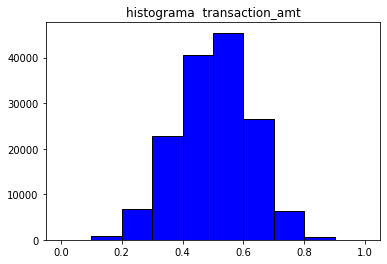

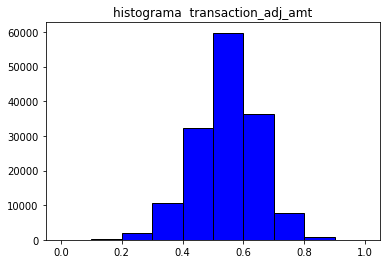

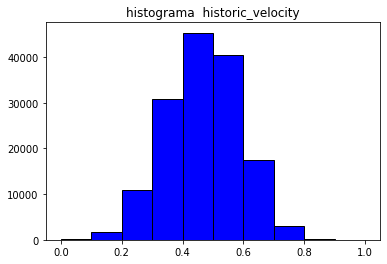

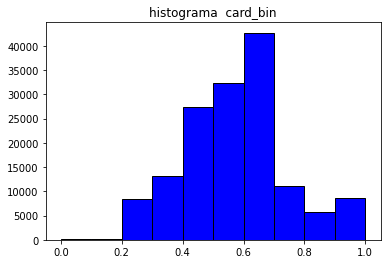

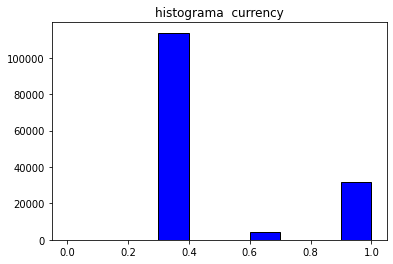

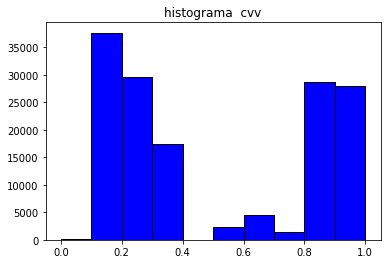

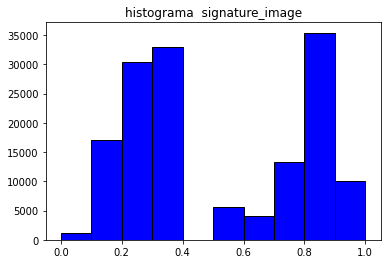

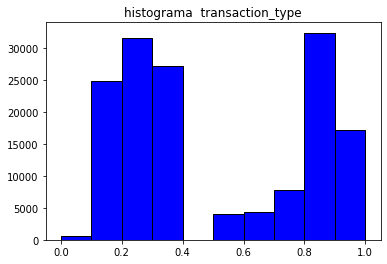

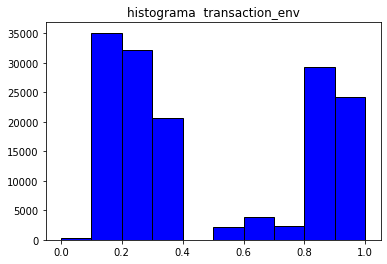

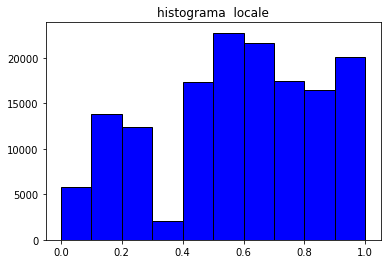

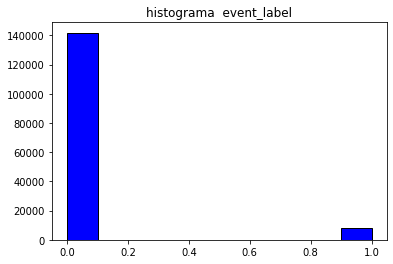

In [ ]:
def crear_histogra(variable,j):
  plt.figure(j)
  plt.hist(df[variable],10,color = "blue" , ec="black")
  plt.title("histograma  "+variable)

variable=list(df.columns.values)

j = 0
k = 0

for i in variable:
  crear_histogra(i,j)
  j+=1
  k+=1

#DIVIDIR EL MODELO PARA LAS PRUEBAS

In [ ]:
df.corr()['event_label']

account_age_days       0.130943
transaction_amt        0.123847
transaction_adj_amt   -0.363767
historic_velocity      0.004135
card_bin               0.003013
currency               0.021240
cvv                    0.000095
signature_image        0.009621
transaction_type      -0.013958
transaction_env        0.009643
locale                -0.001054
event_label            1.000000
Name: event_label, dtype: float64

In [ ]:
#SACAMOS EL TARGET y LOS FEATURES
x = df.drop(['event_label'], axis = 1)
y = df['event_label']

In [ ]:
x

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,card_bin,currency,cvv,signature_image,transaction_type,transaction_env,locale
0,0.369599,0.432920,0.561224,0.253493,0.563824,0.333333,0.153846,0.230769,0.807692,0.923077,0.692833
1,0.297543,0.408490,0.479592,0.448990,0.299356,0.333333,0.923077,0.923077,0.307692,0.884615,0.027304
2,0.766177,0.578094,0.612245,0.498241,0.515236,0.333333,0.923077,0.653846,0.923077,0.923077,0.262799
3,0.297324,0.607729,0.275510,0.600261,0.807643,1.000000,0.269231,0.269231,0.115385,0.538462,0.191126
4,0.394494,0.594914,0.663265,0.256307,0.508612,0.333333,0.923077,0.230769,0.230769,0.269231,0.894198
...,...,...,...,...,...,...,...,...,...,...,...
149995,0.437048,0.577693,0.571429,0.451704,0.389243,0.333333,0.884615,0.153846,0.730769,0.884615,0.976109
149996,0.639724,0.374449,0.612245,0.434114,0.965389,0.333333,0.346154,0.923077,0.884615,1.000000,0.897611
149997,0.524238,0.674009,0.479592,0.511107,0.666228,0.333333,0.153846,0.307692,0.346154,0.153846,0.959044
149998,0.667252,0.460753,0.591837,0.482058,0.322262,0.333333,0.923077,0.807692,1.000000,0.923077,0.556314


In [ ]:
y

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
149995    0.0
149996    0.0
149997    0.0
149998    0.0
149999    0.0
Name: event_label, Length: 150000, dtype: float64

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state= 1)

##APLICAR REGRESION LOGISTICA

In [ ]:
logistic = LogisticRegression(max_iter=3000)

In [ ]:
logistic.fit(x_train, y_train)

LogisticRegression(max_iter=3000)

In [ ]:
y_pred = logistic.predict(x_test)

In [ ]:
accuracy = metrics.accuracy_score(y_test,y_pred)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 96.160%


In [ ]:
precision = metrics.precision_score(y_test, y_pred)
print("Precision : %s" % "{0:.3%}".format(precision))

Precision : 80.623%


##APLICAMOS LA MATRIZ DE CONFUSION

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred, labels=[0, 1])

In [ ]:
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[42315   230]
 [ 1498   957]]


##TECNICA DE PESOS POR LOS DATOS DESBALANCEADOS

In [ ]:
modelo = LogisticRegression(class_weight='balanced',max_iter=3000).fit(x_train, y_train)

In [ ]:
y_pred = modelo.predict(x_test)

In [ ]:
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 85.338%


In [ ]:
precision = metrics.precision_score(y_test, y_pred)
print("Precision : %s" % "{0:.3%}".format(precision))

Precision : 25.123%


In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred, labels=[0, 1])

In [ ]:
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[36310  6235]
 [  363  2092]]


In [ ]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]
print('\nVerdaderos positivos(TP) = ', cm[0,0])

print('\nVerdaderos negativoss(TN) = ', cm[1,1])

print('\nFalsos positivos(FP) = ', cm[0,1])

print('\nFalsos negativos(FN) = ', cm[1,0])


Verdaderos positivos(TP) =  36310

Verdaderos negativoss(TN) =  2092

Falsos positivos(FP) =  6235

Falsos negativos(FN) =  363


##METRICAS DE CLASIFICACION
* Alta precisión y alto recall: el modelo de Machine Learning escogido maneja perfectamente esa clase.
* Alta precisión y bajo recall: el modelo de Machine Learning escogido no detecta la clase muy bien, pero cuando lo hace es altamente confiable.
* Baja precisión y alto recall: El modelo de Machine Learning escogido detecta bien la clase,  pero también incluye muestras de la otra clase.
* Baja precisión y bajo recall: El modelo de Machine Learning escogido no logra clasificar la clase correctamente.

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.92     42545
         1.0       0.25      0.85      0.39      2455

    accuracy                           0.85     45000
   macro avg       0.62      0.85      0.65     45000
weighted avg       0.95      0.85      0.89     45000



##Exactitud
Porcentaje de casos positivos detectados.

In [ ]:
classification_accuracy = (TP + TN) / float(FP + TP + TN + FN)
print('Exactitud de clasificacion : {0:0.4f}%'.format(classification_accuracy))

classification_error = (FP + FN) / float(TP + TN + FP + FN)

print('Error de clasificacion : {0:0.4f}%'.format(classification_error))


Exactitud de clasificacion : 0.8534%
Error de clasificacion : 0.1466%


## **Presicion**

In [ ]:
precision = TP / float(TP + FP)

print('Precision : {0:0.4f}%'.format(precision))

Precision : 0.8534%


##Especificidad
Se trata de los casos negativos que el algoritmo ha clasificado correctamente.

In [ ]:
specificidad = TN / float(TN + FP)
print('Especifidad : {0:0.4f}%'.format(specificidad*100))

Especifidad : 25.1231%


##Sensibilidad (Recall)
Es la proporción de casos positivos que fueron correctamente identificadas por el algoritmo.

In [ ]:
recall = TP / float(TP + FN)
print('Sensibilidad : {0:0.4f}%'.format(recall*100))

Sensibilidad : 99.0102%


##Puntaje F1Score
Esta es otra métrica muy empleada porque nos resume la precisión y sensibilidad en una sola métrica.

In [ ]:
f1_score = 2*(precision + recall) / float(precision + recall)
print('Puntaje F1 : ')
f1_score



Puntaje F1 : 


2.0